# ANÁLISE DO ENEM POR ESCOLA
Base encontrada em http://inep.gov.br/microdados, abrangendo o período de 2005 e 2015.

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 50)

In [2]:
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV

In [3]:
dados = pd.read_csv('DADOS/MICRODADOS_ENEM_ESCOLA.csv', sep=';', encoding='ISO-8859-1')

In [4]:
dados.shape

(172305, 27)

In [5]:
dados = dados.rename(columns={
  "NU_ANO": "ano_edicao",
  "CO_UF_ESCOLA": "cod_uf_escola",
  "SG_UF_ESCOLA": "sigla_uf_escola",
  "CO_MUNICIPIO_ESCOLA": "cod_municipio_escola",
  "NO_MUNICIPIO_ESCOLA": "nome_municipio_escola",
  "CO_ESCOLA_EDUCACENSO": "cod_escola",
  "NO_ESCOLA_EDUCACENSO": "nome_escola",
  "TP_DEPENDENCIA_ADM_ESCOLA": "tipo_dependencia",
  "TP_LOCALIZACAO_ESCOLA": "tipo_localizacao_escola",
  "NU_MATRICULAS": "numero_matriculas",
  "NU_PARTICIPANTES_NEC_ESP": "numero_participantes_especiais",
  "NU_PARTICIPANTES": "numero_participantes",
  "NU_TAXA_PARTICIPACAO": "taxa_participacao",
  "NU_MEDIA_CN": "nota_media_ciencias_natureza",
  "NU_MEDIA_CH": "nota_media_ciencias_humanas",
  "NU_MEDIA_LP": "nota_media_linguagens_codigos",
  "NU_MEDIA_MT": "nota_media_matematica",
  "NU_MEDIA_RED": "nota_media_redacao",
  "NU_MEDIA_OBJ": "nota_media_objetiva",
  "NU_MEDIA_TOT": "nota_media_total",
  "INSE": "indicador_socio_economico_escola",
  "PC_FORMACAO_DOCENTE": "indicador_adequacao_escola",
  "NU_TAXA_PERMANENCIA": "indicador_permanencia_escola",
  "NU_TAXA_APROVACAO": "taxa_aprovacao",
  "NU_TAXA_REPROVACAO": "taxa_reprovacao",
  "NU_TAXA_ABANDONO": "taxa_abandono",
  "PORTE_ESCOLA": "porte_escola"
})

In [6]:
dados.dtypes

ano_edicao                            int64
cod_uf_escola                         int64
sigla_uf_escola                      object
cod_municipio_escola                  int64
nome_municipio_escola                object
cod_escola                            int64
nome_escola                          object
tipo_dependencia                      int64
tipo_localizacao_escola               int64
numero_matriculas                     int64
numero_participantes_especiais      float64
numero_participantes                  int64
taxa_participacao                   float64
nota_media_ciencias_natureza        float64
nota_media_ciencias_humanas         float64
nota_media_linguagens_codigos       float64
nota_media_matematica               float64
nota_media_redacao                  float64
nota_media_objetiva                 float64
nota_media_total                    float64
indicador_socio_economico_escola     object
indicador_adequacao_escola          float64
indicador_permanencia_escola    

In [7]:
mask_1 = dados['ano_edicao'] >= 2009
mask_2 = dados['sigla_uf_escola'] == 'SP'
mask_3 = dados['sigla_uf_escola'] == 'ES'
mask_4 = dados['sigla_uf_escola'] == 'RJ'
mask_5 = dados['sigla_uf_escola'] == 'MG'
dados_filtrados = dados[(mask_1) & (mask_2 | mask_3 | mask_4 | mask_5)]
del dados_filtrados['nota_media_total']
del dados_filtrados['nota_media_objetiva']
dados_filtrados.shape

(46243, 25)

In [8]:
dados_filtrados['sigla_uf_escola'].value_counts()

SP    23004
MG    12202
RJ     8401
ES     2636
Name: sigla_uf_escola, dtype: int64

In [9]:
dados_filtrados['nome_municipio_escola'].value_counts()

São Paulo          4556
Rio de Janeiro     2882
Belo Horizonte     1289
Campinas            559
Guarulhos           520
                   ... 
Sagres                1
Inúbia Paulista       1
Salmourão             1
Bugre                 1
Glicério              1
Name: nome_municipio_escola, Length: 1635, dtype: int64

In [10]:
dados_filtrados['nome_escola'].value_counts()

COLEGIO TIRADENTES PMMG             91
COLEGIO E CURSO PONTO DE ENSINO     72
SAO JOSE COLEGIO                    51
SISTEMA ELITE DE ENSINO             50
SEBRAE ESC TEC DE FORM GERENCIAL    46
                                    ..
EE MONS GUSTAVO                      1
COL CENECISTA SUL PARAIBANO          1
IFSULDEMINAS - CAMPUS MACHADO        1
EE DR RENATO AZEREDO                 1
EM SEC HUMBERTO ALMEIDA              1
Name: nome_escola, Length: 14023, dtype: int64

In [11]:
dados_filtrados['indicador_socio_economico_escola'].value_counts()

Grupo 5    1957
Grupo 4    1935
Grupo 3    1857
Grupo 6     920
Grupo 2     148
Grupo 1      28
Name: indicador_socio_economico_escola, dtype: int64

In [12]:
dados_filtrados['porte_escola'].value_counts()

Maior que 90 alunos    15369
De 1 a 30 alunos       12204
De 31 a 60 alunos      11407
De 61 a 90 alunos       7263
Name: porte_escola, dtype: int64

In [13]:
numeric_cols = dados_filtrados.select_dtypes(include=np.number).columns.tolist()
print(len(numeric_cols))
print(numeric_cols)

20
['ano_edicao', 'cod_uf_escola', 'cod_municipio_escola', 'cod_escola', 'tipo_dependencia', 'tipo_localizacao_escola', 'numero_matriculas', 'numero_participantes_especiais', 'numero_participantes', 'taxa_participacao', 'nota_media_ciencias_natureza', 'nota_media_ciencias_humanas', 'nota_media_linguagens_codigos', 'nota_media_matematica', 'nota_media_redacao', 'indicador_adequacao_escola', 'indicador_permanencia_escola', 'taxa_aprovacao', 'taxa_reprovacao', 'taxa_abandono']


In [14]:
numeric_cols = [
    'tipo_dependencia', 'tipo_localizacao_escola', 'numero_matriculas',
    'numero_participantes_especiais', 'numero_participantes', 'taxa_participacao',
    'nota_media_ciencias_natureza', 'nota_media_ciencias_humanas', 'nota_media_linguagens_codigos',
    'nota_media_matematica', 'nota_media_redacao', 'indicador_adequacao_escola',
    'indicador_permanencia_escola', 'taxa_aprovacao', 'taxa_reprovacao', 'taxa_abandono'
]

In [15]:
describe = dados_filtrados[numeric_cols].describe()

In [16]:
aux = list()
for col in describe.columns:
    aux.append({
        'coluna': col,
        'media': describe.loc['mean', col],
        'min': describe.loc['min', col],
        '25%': describe.loc['25%', col],
        '50%': describe.loc['50%', col],
        '75%': describe.loc['75%', col],
        'max': describe.loc['max', col],
        'desvio_padrao': describe.loc['std', col],
        'coeficiente_de_variacao': describe.loc['std', col]/describe.loc['mean', col]
    })

cv = pd.DataFrame(aux)
cv

,coluna,media,min,25%,50%,75%,max,desvio_padrao,coeficiente_de_variacao
0,tipo_dependencia,2.85868,1.00000,2.00000,2.00000,4.00000,4.00000,0.99889,0.34942
1,tipo_localizacao_escola,1.02563,1.00000,1.00000,1.00000,1.00000,2.00000,0.15802,0.15407
2,numero_matriculas,86.86761,0.00000,29.00000,59.00000,115.00000,1038.00000,84.99862,0.97848
3,numero_participantes_especiais,0.29398,0.00000,0.00000,0.00000,0.00000,27.00000,0.89626,3.04870
4,numero_participantes,51.88342,10.00000,19.00000,34.00000,64.00000,670.00000,53.49370,1.03104
5,taxa_participacao,65.10767,3.80000,51.30000,66.70000,85.29000,100.00000,23.63627,0.36303
6,nota_media_ciencias_natureza,504.90407,372.31000,464.02500,490.31000,540.98000,755.16000,53.58149,0.10612
7,nota_media_ciencias_humanas,544.96059,368.10000,504.98000,540.78000,584.68500,758.04000,55.65068,0.10212
8,nota_media_linguagens_codigos,525.70507,363.34000,492.10000,519.14000,560.14500,712.35000,45.91963,0.08735
9,nota_media_matematica,535.36639,370.48000,476.26000,514.65000,588.14000,873.65000,75.68077,0.14136


In [17]:
notas = [
    'nota_media_ciencias_natureza', 'nota_media_ciencias_humanas', 'nota_media_linguagens_codigos',
    'nota_media_matematica', 'nota_media_redacao'
]

nao_notas = [
    'tipo_dependencia', 'tipo_localizacao_escola', 'numero_matriculas',
    'numero_participantes_especiais', 'numero_participantes', 'taxa_participacao',
    'indicador_adequacao_escola', 'indicador_permanencia_escola', 'taxa_aprovacao',
    'taxa_reprovacao', 'taxa_abandono'
]


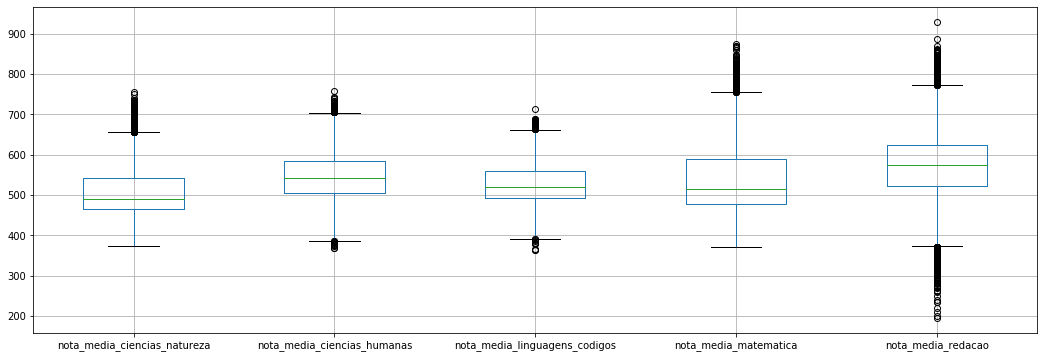

In [18]:
boxplot = dados_filtrados.boxplot(column=notas, figsize=(18,6))
plt.show()

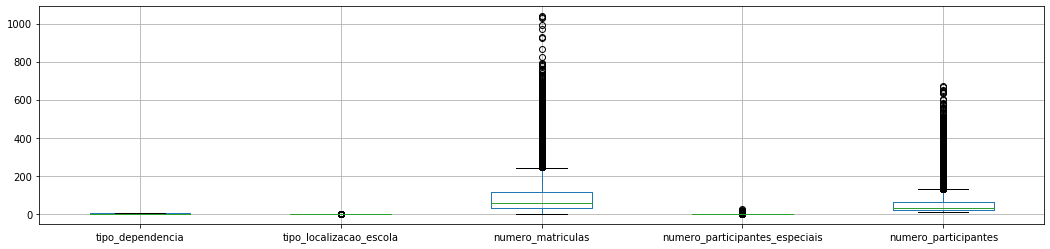

In [19]:
boxplot = dados_filtrados.boxplot(column=nao_notas[0:5], figsize=(18,4))
plt.show()

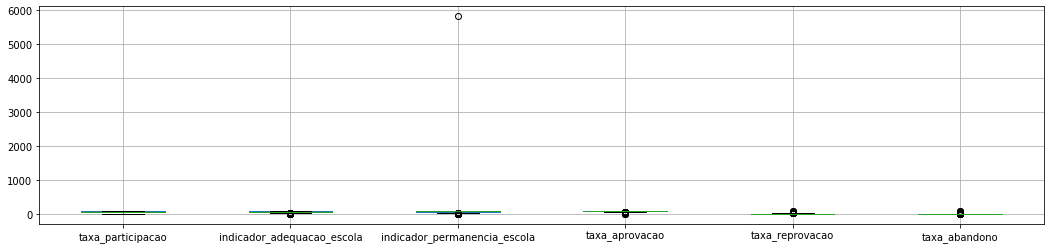

In [20]:
boxplot = dados_filtrados.boxplot(column=nao_notas[5:], figsize=(18,4))
plt.show()

In [21]:
dados_filtrados.isna().sum()

ano_edicao                              0
cod_uf_escola                           0
sigla_uf_escola                         0
cod_municipio_escola                    0
nome_municipio_escola                   0
cod_escola                              0
nome_escola                             0
tipo_dependencia                        0
tipo_localizacao_escola                 0
numero_matriculas                       0
numero_participantes_especiais      26558
numero_participantes                    0
taxa_participacao                       0
nota_media_ciencias_natureza            0
nota_media_ciencias_humanas             0
nota_media_linguagens_codigos           0
nota_media_matematica                   0
nota_media_redacao                    163
indicador_socio_economico_escola    39398
indicador_adequacao_escola          26568
indicador_permanencia_escola        32813
taxa_aprovacao                        440
taxa_reprovacao                       440
taxa_abandono                     

# Analisando a presença de outliers

In [22]:
def obtem_outlier(df, col):
    std = df[col].std()
    mean = df[col].mean()
    limite_superior = mean + (3 * std)
    limite_inferior = mean - (3 * std)
    contagem = df[(df[col] < limite_inferior) | (df[col] > limite_superior)].shape[0]
    return contagem

rows_outlier = list()
for col in numeric_cols:
    contagem_outlier = obtem_outlier(dados_filtrados, col)
    porcentagem_outlier = round((contagem_outlier/dados_filtrados.shape[0])*100, 5)
    rows_outlier.append(
        {
            'coluna': col,
            'contagem_outliers': contagem_outlier,
            'porcentagem_outliers': f"{str(porcentagem_outlier)} %"
        }
    )

outliers = pd.DataFrame(rows_outlier)
outliers.sort_values(by='contagem_outliers', ascending=False)

,coluna,contagem_outliers,porcentagem_outliers
1,tipo_localizacao_escola,1185,2.56255 %
4,numero_participantes,989,2.1387 %
2,numero_matriculas,917,1.983 %
15,taxa_abandono,824,1.78189 %
14,taxa_reprovacao,629,1.36021 %
13,taxa_aprovacao,504,1.08989 %
3,numero_participantes_especiais,486,1.05097 %
6,nota_media_ciencias_natureza,227,0.49089 %
10,nota_media_redacao,215,0.46494 %
9,nota_media_matematica,201,0.43466 %


# CONTAGEM DE NA's
Por se tratar de informações governamentais, é esperado que a base seja preenchida com certo critério e objetividade. Porém, fazendo uma "pré análise" com a abertura do arquivo excel na minha própia máquina, de fato notei que existiam muitas informações faltantes.

In [23]:
def contagem_na(df, col):
    return df[col].isna().sum()

na_rows = []
for col in numeric_cols:
    total = contagem_na(dados_filtrados, col)
    porcentagem_total = round((total/dados_filtrados.shape[0])*100, 4)
    na_rows.append({
        'coluna': col,
        'contagem_na': total,
        'porcentagem_na': f"{str(porcentagem_total)} %"
    })

dados_na = pd.DataFrame(na_rows)
dados_na.sort_values(by='contagem_na', ascending=False)

,coluna,contagem_na,porcentagem_na
12,indicador_permanencia_escola,32813,70.9578 %
11,indicador_adequacao_escola,26568,57.453 %
3,numero_participantes_especiais,26558,57.4314 %
13,taxa_aprovacao,440,0.9515 %
14,taxa_reprovacao,440,0.9515 %
15,taxa_abandono,440,0.9515 %
10,nota_media_redacao,163,0.3525 %
0,tipo_dependencia,0,0.0 %
1,tipo_localizacao_escola,0,0.0 %
2,numero_matriculas,0,0.0 %


Nota-se que não temos dados para nota_media_objetiva e nem nota_media_total, pois segundo a nota divulgada junto com os dados, essas notas foram calculadas somente em 2008 e entre 2005 e 2007, respectivamente.

# Preenchendo NA's com a mediana
Optei por preencher com a mediana por conta dos outliers (mesmo notando que a quantidade não é alarmante), que pode gerar uma média não condizente com a realidade. A mediana nesse caso é a melhor medida a ser usada.

In [24]:
dados_filtrados['indicador_permanencia_escola'] = dados_filtrados['indicador_permanencia_escola'].fillna(dados_filtrados['indicador_permanencia_escola'].median())
dados_filtrados['indicador_adequacao_escola'] = dados_filtrados['indicador_adequacao_escola'].fillna(dados_filtrados['indicador_adequacao_escola'].median())
dados_filtrados['numero_participantes_especiais'] = dados_filtrados['numero_participantes_especiais'].fillna(dados_filtrados['numero_participantes_especiais'].median())
dados_filtrados['taxa_aprovacao'] = dados_filtrados['taxa_aprovacao'].fillna(dados_filtrados['taxa_aprovacao'].median())
dados_filtrados['taxa_reprovacao'] = dados_filtrados['taxa_reprovacao'].fillna(dados_filtrados['taxa_reprovacao'].median())
dados_filtrados['taxa_abandono'] = dados_filtrados['taxa_abandono'].fillna(dados_filtrados['taxa_abandono'].median())
dados_filtrados['nota_media_redacao'] = dados_filtrados['nota_media_redacao'].fillna(dados_filtrados['nota_media_redacao'].median())

# Preenchendo NA's com "Não informado"
Nesse caso, por se tratar de uma coluna não numérica, optei por preencher com uma string relatando que a informação não foi informada.

In [25]:
dados_filtrados['indicador_socio_economico_escola'] = dados_filtrados['indicador_socio_economico_escola'].fillna("Não informado")

In [26]:
dados_filtrados.dtypes

ano_edicao                            int64
cod_uf_escola                         int64
sigla_uf_escola                      object
cod_municipio_escola                  int64
nome_municipio_escola                object
cod_escola                            int64
nome_escola                          object
tipo_dependencia                      int64
tipo_localizacao_escola               int64
numero_matriculas                     int64
numero_participantes_especiais      float64
numero_participantes                  int64
taxa_participacao                   float64
nota_media_ciencias_natureza        float64
nota_media_ciencias_humanas         float64
nota_media_linguagens_codigos       float64
nota_media_matematica               float64
nota_media_redacao                  float64
indicador_socio_economico_escola     object
indicador_adequacao_escola          float64
indicador_permanencia_escola        float64
taxa_aprovacao                      float64
taxa_reprovacao                 

In [27]:
dados_filtrados.drop(columns=['sigla_uf_escola', 'nome_municipio_escola', 'nome_escola', 'indicador_socio_economico_escola'], axis=1, inplace=True)

In [28]:
my_map = {
    "Maior que 90 alunos": 1,
    "De 1 a 30 alunos": 2,
    "De 31 a 60 alunos": 3,
    "De 61 a 90 alunos": 4
}

dados_filtrados.loc[:, 'porte_escola'] = dados_filtrados.loc[:, 'porte_escola'].apply(lambda x: my_map[x])

In [29]:
print(dados_filtrados.shape)
dados_filtrados.dtypes

(46243, 21)


ano_edicao                          int64
cod_uf_escola                       int64
cod_municipio_escola                int64
cod_escola                          int64
tipo_dependencia                    int64
tipo_localizacao_escola             int64
numero_matriculas                   int64
numero_participantes_especiais    float64
numero_participantes                int64
taxa_participacao                 float64
nota_media_ciencias_natureza      float64
nota_media_ciencias_humanas       float64
nota_media_linguagens_codigos     float64
nota_media_matematica             float64
nota_media_redacao                float64
indicador_adequacao_escola        float64
indicador_permanencia_escola      float64
taxa_aprovacao                    float64
taxa_reprovacao                   float64
taxa_abandono                     float64
porte_escola                        int64
dtype: object

In [30]:
## ponderar a média

dados_filtrados['nota_media_geral'] = ((0.1*dados_filtrados['nota_media_ciencias_natureza']) + (0.1*dados_filtrados['nota_media_ciencias_humanas']) + (0.1*dados_filtrados['nota_media_linguagens_codigos']) + (0.7*dados_filtrados['nota_media_matematica']))

In [31]:
dados_filtrados['nota_media_geral'].describe()

count   46243.00000
mean      532.31345
std        66.15232
min       389.55700
25%       480.33450
50%       513.05100
75%       579.92500
max       824.70500
Name: nota_media_geral, dtype: float64

In [32]:
def calcular_target(row):
    if (row['nota_media_geral'] >= 576) & (row['nota_media_redacao'] > 450):
        return 1
    return 0

In [33]:
dados_filtrados['target'] = dados_filtrados.apply(lambda x: calcular_target(x), axis=1) 

In [34]:
dados_filtrados['target'].value_counts()

0    34072
1    12171
Name: target, dtype: int64

In [35]:
dados_filtrados[
    ['nota_media_ciencias_natureza', 'nota_media_ciencias_humanas', 'nota_media_linguagens_codigos',
    'nota_media_matematica', 'nota_media_redacao', 'target']
].corr()

,nota_media_ciencias_natureza,nota_media_ciencias_humanas,nota_media_linguagens_codigos,nota_media_matematica,nota_media_redacao,target
nota_media_ciencias_natureza,1.00000,0.84373,0.89901,0.87893,0.76081,0.77853
nota_media_ciencias_humanas,0.84373,1.00000,0.84648,0.74155,0.66478,0.66906
nota_media_linguagens_codigos,0.89901,0.84648,1.00000,0.85257,0.74929,0.73287
nota_media_matematica,0.87893,0.74155,0.85257,1.00000,0.71014,0.83491
nota_media_redacao,0.76081,0.66478,0.74929,0.71014,1.00000,0.60688
target,0.77853,0.66906,0.73287,0.83491,0.60688,1.00000


# Balanceamento

In [36]:
df_1 = dados_filtrados[dados_filtrados['target'] == 0].head(13000)
df_2 = dados_filtrados[dados_filtrados['target'] == 1].head(12171)

dados_filtrados = pd.concat([df_1, df_2])

dados_filtrados['target'].value_counts()

0    13000
1    12171
Name: target, dtype: int64

In [37]:
dados_filtrados['nota_media_geral'].describe()

count   25171.00000
mean      557.75804
std        74.59846
min       389.55700
25%       489.58650
50%       565.68800
75%       616.23300
max       824.70500
Name: nota_media_geral, dtype: float64

In [38]:
nota_media_geral = 500
acima_media_count = dados_filtrados[dados_filtrados['nota_media_geral'] >= nota_media_geral].shape[0]
abaixo_media_count = dados_filtrados[dados_filtrados['nota_media_geral'] < nota_media_geral].shape[0]
print(acima_media_count)
print(abaixo_media_count)

17367
7804


In [39]:
## separar em duas bases (acima da média e abaixo da média)
## 70% acima e abaixo na base de treino
## 30% acima e abaixo na base de teste

acima_da_media = dados_filtrados[dados_filtrados['nota_media_geral'] >= nota_media_geral]
abaixo_da_media = dados_filtrados[dados_filtrados['nota_media_geral'] < nota_media_geral]

head_acima = round(acima_media_count*0.7)
head_abaixo = round(abaixo_media_count*0.7)

acima_da_media_70 = acima_da_media.head(head_acima)
abaixo_da_media_70 = abaixo_da_media.head(head_abaixo)

treino = pd.concat([acima_da_media_70, abaixo_da_media_70])

In [40]:
acima_da_media_30 = acima_da_media.iloc[head_acima+1:-1]
abaixo_da_media_30 = abaixo_da_media.iloc[head_abaixo+1:-1]

teste = pd.concat([acima_da_media_30, abaixo_da_media_30])

In [41]:
explicativas = dados_filtrados.drop(columns=['target'])
target = dados_filtrados['target']

# SELEÇÃO DE VARIÁVEIS

In [42]:
vars_norm = MinMaxScaler().fit_transform(explicativas)
chi_selector = SelectKBest(chi2)
chi_selector.fit(explicativas, target)
chi_support = chi_selector.get_support()
chi_feature = explicativas.loc[:, chi_support].columns.tolist()
print(str(len(chi_feature)), 'são as quantidades de vars selecionadas')
print(chi_feature)

10 são as quantidades de vars selecionadas
['cod_municipio_escola', 'cod_escola', 'numero_matriculas', 'nota_media_ciencias_natureza', 'nota_media_ciencias_humanas', 'nota_media_linguagens_codigos', 'nota_media_matematica', 'nota_media_redacao', 'taxa_abandono', 'nota_media_geral']


In [43]:
rfe_selector = RFE(
    estimator=LogisticRegression(random_state=123),
    step=10,
    n_features_to_select=5
)
rfe_selector.fit(explicativas, target)
rfe_support = rfe_selector.get_support()
rfe_feature = explicativas.loc[:, rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'são as quantidades de vars selecionadas')
print(rfe_feature)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


5 são as quantidades de vars selecionadas
['ano_edicao', 'cod_uf_escola', 'tipo_dependencia', 'nota_media_matematica', 'nota_media_geral']


D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [44]:
rf_selector = SelectFromModel(RandomForestClassifier(
    n_estimators=100, random_state=123))
rf_selector.fit(explicativas, target)
rf_support = rf_selector.get_support()
rf_feature = explicativas.loc[:, rf_support].columns.tolist()
print(str(len(rf_feature)), "são as quantidades de vars selecionadas")
print(rf_feature)

7 são as quantidades de vars selecionadas
['cod_escola', 'tipo_dependencia', 'nota_media_ciencias_natureza', 'nota_media_ciencias_humanas', 'nota_media_linguagens_codigos', 'nota_media_matematica', 'nota_media_geral']


In [45]:
feature_selection_df = pd.DataFrame({
    'Variáveis': explicativas.columns,
    'Chi-2': chi_support,
    'RFE': rfe_support,
    'RF': rf_support})

In [46]:
# count de quanto foi selecionado para cada um dos algoritmos
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# sort
feature_selection_df = feature_selection_df.sort_values(
    ['Total', 'Variáveis'], ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df

,Variáveis,Chi-2,RFE,RF,Total
1,nota_media_matematica,True,True,True,3
2,nota_media_geral,True,True,True,3
3,tipo_dependencia,False,True,True,2
4,nota_media_linguagens_codigos,True,False,True,2
5,nota_media_ciencias_natureza,True,False,True,2
6,nota_media_ciencias_humanas,True,False,True,2
7,cod_escola,True,False,True,2
8,taxa_abandono,True,False,False,1
9,numero_matriculas,True,False,False,1
10,nota_media_redacao,True,False,False,1


In [47]:
filter_cols = feature_selection_df[feature_selection_df['Total'] > 0]
cols_to_filter = filter_cols['Variáveis'].unique()

result = []
for col in cols_to_filter:
    if not 'nota' in col:
        result.append(col)

result

['tipo_dependencia',
 'cod_escola',
 'taxa_abandono',
 'numero_matriculas',
 'cod_uf_escola',
 'cod_municipio_escola',
 'ano_edicao']

In [48]:
x_treino = treino.drop(columns=['target'])
x_treino = x_treino[result]
y_treino = treino['target']

x_teste = teste.drop(columns=['target'])
x_teste = x_teste[result]
y_teste = teste['target']

# Regressão Logística

In [49]:
reg = LogisticRegression(random_state=123)
reg.fit(x_treino, y_treino)
acc_reg_treino = reg.score(x_treino, y_treino)
acc_reg_teste = reg.score(x_teste, y_teste)
acc_reg_treino = round(acc_reg_treino*100, 2)
acc_reg_teste = round(acc_reg_teste*100, 2)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Árvore de Decisão

In [50]:
tree = DecisionTreeClassifier(random_state=123, splitter="random", max_depth=2)
tree.fit(x_treino, y_treino)

y_tree_treino = tree.predict(x_treino)
y_tree_teste = tree.predict(x_teste)

y_score_tree_treino = tree.predict_proba(x_treino)[:, 1]
y_score_tree_teste = tree.predict_proba(x_teste)[:, 1]

acc_tree_treino = round(accuracy_score(y_tree_treino, y_treino)*100, 2)
acc_tree_teste = round(accuracy_score(y_tree_teste, y_teste)*100, 2)
print(acc_tree_treino)
print(acc_tree_teste)

77.11
87.89


# Comparação dos modelos

In [51]:
# criar um df para comparação de modelos
modelos = pd.DataFrame({
    'Modelo': ['Regressão', 'Árvore'],
    'Acuracia de treino': [
        acc_reg_treino,
        acc_tree_treino],
    'Acuracia de teste': [
        acc_reg_teste,
        acc_tree_teste
    ]
})

modelos

,Modelo,Acuracia de treino,Acuracia de teste
0,Regressão,64.53000,45.91000
1,Árvore,77.11000,87.89000


# ML COM GRIDSEARCH

In [52]:
parameters = {  
    "n_estimators": [100, 200, 400, 800],
    "criterion": ["gini", "entropy"]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(),
    parameters,
    n_jobs=-1,
    verbose=0,
    cv=10
)

grid_search_rf.fit(x_treino, y_treino)  
print("Best score: {0}".format(grid_search_rf.best_score_))
print("Best estimator: {0}".format(grid_search_rf.best_estimator_))
print("Best params: {0}".format(grid_search_rf.best_params_))

Best score: 0.7414869466515324
Best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best params: {'criterion': 'gini', 'n_estimators': 100}


In [61]:
y_pred_rf = grid_search_rf.predict(x_teste)

print(confusion_matrix(y_teste, y_pred_rf))

[[2328   11]
 [   0 5208]]


In [53]:
parameters = {  
    "loss": ["deviance", "exponential"],
    "n_estimators": [100, 200, 400, 800]
}

grid_search_gb = GridSearchCV(
    GradientBoostingClassifier(),
    parameters,
    n_jobs=-1,
    verbose=0,
    cv=10
)

grid_search_gb.fit(x_treino, y_treino)  
print("Best score: {0}".format(grid_search_gb.best_score_))
print("Best estimator: {0}".format(grid_search_gb.best_estimator_))
print("Best params: {0}".format(grid_search_gb.best_params_))

Best score: 0.7391600454029512
Best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Best params: {'loss': 'deviance', 'n_estimators': 100}


In [71]:
y_pred_gb = grid_search_gb.predict(x_teste)

conf = confusion_matrix(y_teste, y_pred_gb)
conf

array([[2323,   16],
       [   0, 5208]], dtype=int64)